In [1]:
%matplotlib inline
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import igraph
import leidenalg

In [66]:
# read in subsetted ann data object
adata = sc.read_h5ad("/w5home/bmoore/scRNAseq/GAMM/GAMM_S2/output_20230830_155530/GAMM_S2_clabeled-clusters_0.5_cones_orthologs.h5ad")
adata


AnnData object with n_obs × n_vars = 516 × 16711
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'percent.mt', 'sizeFactors', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.5', 'seurat_clusters', 'CellType', 'CellType_manual'
    var: 'features', 'old_names'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances'

In [3]:
# get correct gene names based on gene list
def main_gene_selection(X_df, gene_list):
    """
    Describe:
        rebuild the input adata to select target genes encode protein 
    Parameters:
        adata->`~anndata.AnnData` object: adata with var index_name by gene symbol
        gene_list->list: wanted target gene 
    Returns:
        adata_new->`~anndata.AnnData` object
        to_fill_columns->list: zero padding gene
    """
    to_fill_columns = list(set(gene_list) - set(X_df.columns))
    padding_df = pd.DataFrame(np.zeros((X_df.shape[0], len(to_fill_columns))), 
                              columns=to_fill_columns, 
                              index=X_df.index)
    X_df = pd.DataFrame(np.concatenate([df.values for df in [X_df, padding_df]], axis=1), 
                        index=X_df.index, 
                        columns=list(X_df.columns) + list(padding_df.columns))
    X_df = X_df[gene_list]
    
    var = pd.DataFrame(index=X_df.columns)
    var['mask'] = [1 if i in to_fill_columns else 0 for i in list(var.index)]
    return X_df, to_fill_columns,var

gene_list_df = pd.read_csv('/w5home/bmoore/scFoundation/model/OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
gene_list = list(gene_list_df['gene_name'])
X_df= adata.to_df()
X_df, to_fill_columns, var = main_gene_selection(X_df, gene_list)
print(X_df)

                        A1BG      A1CF       A2M     A2ML1   A3GALT2  \
AAACGAAGTTTCGGCG_1 -0.042346 -0.105030 -0.427844 -0.184739 -0.036179   
AAACGAATCGTCTACC_1 -0.043150  6.128100 -0.379275 -0.179870 -0.040108   
AACAAGACAACGATTC_1 -0.037658 -0.103802 -0.357409 -0.204344 -0.052037   
AACAGGGAGTCATAGA_1 -0.044894 -0.102238 -0.508249 -0.175131 -0.022941   
AACCACATCACCCTTG_1 -0.042375 -0.106361 -0.412149 -0.184219 -0.037850   
...                      ...       ...       ...       ...       ...   
TTTACCACACTGTCGG_2 -0.039420 -0.097577 -0.465289 -0.199000 -0.037152   
TTTCATGAGCCAGAGT_2 -0.037614 -0.093242 -0.485196 -0.207719 -0.038104   
TTTGGAGCAGAAGCGT_2 -0.044068 -0.110562 -0.391849 -0.176000 -0.037136   
TTTGGAGCAGGAGACT_2 -0.045522 -0.111476 -0.407204 -0.169757 -0.032928   
TTTGGTTGTCTTCTAT_2 -0.041736 -0.103496 -0.435414 -0.187704 -0.036407   

                      A4GALT     A4GNT      AAAS      AACS     AADAC  ...  \
AAACGAAGTTTCGGCG_1 -0.076534 -0.036593 -0.261514 -0.318321

In [4]:
import skmisc
# turn back to anndata object
#get variable gene_list
adata = sc.AnnData(X_df)
sc.pp.highly_variable_genes(adata) # ,flavor="seurat_v3"

/w5home/bmoore/miniconda3/envs/scfound2/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [5]:
hvg_mask = adata.var['highly_variable'].values
print(hvg_mask)

[False  True False ... False False False]


In [6]:
hvg_indices = np.where(hvg_mask)[0]
print(len(hvg_indices))

3125


In [7]:
# get embedding
cell_geneemb = np.load('/w5home/bmoore/scRNAseq/GAMM/GAMM_S2/Gamm_gene_embed/Gamm_01B-resolution_sc_gene_embedding_a5_cones-orthos.npy')

In [8]:
print(cell_geneemb)

[[[            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]
  ...
  [            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]]

 [[-6.92784712e-02  4.02336717e-02  6.18375018e-02 ...  5.92425205e-02
   -4.71354797e-02 -7.37854242e-02]
  [-2.90654786e-02  1.18232556e-01 -4.62347120e-02 ...  2.64367014e-01
   -8.53215754e-02 -1.75835326e-01]
  [-2.14098692e-01 -1.27610832e-01  1.59268841e-01 ...  7.89054856e-02
    1.71321929e-02 -2.16537789e-01]
  ...
  [ 3.32181691e-03 -9.6

In [9]:
#len(cell_geneemb[:, 0, :])
print(cell_geneemb[:, :, 0].shape)
cell_geneemb[:, :, 0]

(516, 19264)


array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.06927847, -0.02906548, -0.21409869, ...,  0.00332182,
         0.03509479,  0.12891768],
       [-0.09768425, -0.09234037, -0.10505378, ..., -0.00229022,
        -0.0182545 ,  0.107095  ],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.07920763, -0.0999092 , -0.09874845, ...,  0.08379408,
         0.00828315, -0.01799495],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

In [10]:
# get variable genes and merge with embedding

# Get boolean mask of highly variable genes
# hvg_mask = adata.var['highly_variable']

# # Get indices where genes are highly variable
# hvg_indices = np.where(hvg_mask)[0]

# Now you can use these indices with your gene embeddings
#geneemb_merge = cell_geneemb[:, hvg_indices, :].mean(0)
geneemb_merge = cell_geneemb[:, :, 0]
#geneemb_merge = cell_geneemb[:,selected_gene,:].mean(0)
#geneemb_merge.shape
print(geneemb_merge)
print(geneemb_merge.shape)
# geneemb_merge_t = np.transpose(geneemb_merge)
# valid_cells = ~np.isnan(geneemb_merge_t).any(axis=1)
# valid_genes = ~np.isnan(geneemb_merge_t).any(axis=0)
# print(valid_cells)
# print(valid_genes)

[[        nan         nan         nan ...         nan         nan
          nan]
 [-0.06927847 -0.02906548 -0.21409869 ...  0.00332182  0.03509479
   0.12891768]
 [-0.09768425 -0.09234037 -0.10505378 ... -0.00229022 -0.0182545
   0.107095  ]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [-0.07920763 -0.0999092  -0.09874845 ...  0.08379408  0.00828315
  -0.01799495]
 [        nan         nan         nan ...         nan         nan
          nan]]
(516, 19264)


In [11]:

# check that anndata and gene embddings line up
anndata_genes = adata.var_names.tolist()
# Check dimensions
print(f"Number of genes in AnnData: {len(anndata_genes)}")
print(f"Number of genes in embeddings: {cell_geneemb.shape[1]}")


Number of genes in AnnData: 19264
Number of genes in embeddings: 19264


In [12]:
print(len(anndata_genes), len(gene_list))
hvg_genes=np.array(anndata_genes)[hvg_indices]
print(hvg_genes, len(hvg_genes))

19264 19264
['A1CF' 'A2ML1' 'AAAS' ... 'ZSWIM9' 'ZW10' 'ZWILCH'] 3125


In [13]:
gene_df = pd.DataFrame(geneemb_merge,columns=anndata_genes)
print(gene_df)
gene_df_hvg =gene_df[hvg_genes]
print(gene_df_hvg)

         A1BG      A1CF       A2M     A2ML1   A3GALT2    A4GALT     A4GNT  \
0         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1   -0.069278 -0.029065 -0.214099 -0.005372 -0.058932 -0.047527  0.005206   
2   -0.097684 -0.092340 -0.105054  0.004172 -0.051394 -0.063024  0.030592   
3         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4   -0.068726 -0.077428 -0.128097 -0.003263 -0.049141 -0.063823  0.015812   
..        ...       ...       ...       ...       ...       ...       ...   
511 -0.071202 -0.100276 -0.098706  0.015107 -0.042486 -0.065167  0.045055   
512 -0.078018 -0.108053 -0.110498  0.009195 -0.054351 -0.064812  0.036263   
513       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
514 -0.079208 -0.099909 -0.098748  0.013776 -0.044926 -0.094632  0.038794   
515       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

         AAAS      AACS     AADAC  ...    ZWILCH     ZWINT      ZXDA  \
0  

In [14]:
# add gene names into merged embeddings
gene_adata=sc.AnnData(gene_df)
print(gene_adata)
gene_adata_hvg=sc.AnnData(gene_df_hvg)
print(gene_adata_hvg)

AnnData object with n_obs × n_vars = 516 × 19264
AnnData object with n_obs × n_vars = 516 × 3125


/w5home/bmoore/miniconda3/envs/scfound2/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/w5home/bmoore/miniconda3/envs/scfound2/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
print(gene_adata_hvg.X.shape)
print(gene_adata_hvg.shape)

(516, 3125)
(516, 3125)


In [16]:
valid_genes = ~np.isnan(gene_adata_hvg.X).any(axis=0)
print(valid_genes)
# gene_adata_hvg = gene_adata_hvg[:, valid_genes]
# gene_adata_hvg
valid_cells = ~np.isnan(gene_adata_hvg.X).any(axis=1)
print(valid_cells)
gene_adata_hvg= gene_adata_hvg[valid_cells, :]
gene_adata_hvg


[False False False ... False False False]
[False  True  True False  True  True  True False False False  True False
  True  True False  True False  True  True  True  True  True  True  True
 False  True  True False  True  True False  True False  True  True False
  True  True  True  True  True  True  True False  True  True False  True
 False False  True  True  True False  True  True False  True  True  True
  True False  True  True  True False  True False False False  True False
  True  True False False  True  True  True  True False False  True  True
 False False False False  True  True  True  True False  True  True  True
 False  True False False False False  True False False  True  True  True
 False False  True  True  True  True  True False  True  True False  True
 False False  True  True False False  True False  True  True  True False
 False False  True  True  True  True False  True  True  True  True  True
  True False  True False  True  True  True  True  True  True False  True
 False  T

View of AnnData object with n_obs × n_vars = 343 × 3125

In [17]:
gene_adata_hvg.var_names
gene_adata_hvg.obs_names

Index(['1', '2', '4', '5', '6', '10', '12', '13', '15', '17',
       ...
       '501', '502', '503', '507', '508', '509', '510', '511', '512', '514'],
      dtype='object', length=343)

In [56]:
sc.pp.neighbors(gene_adata_hvg,use_rep='X')
sc.tl.umap(gene_adata_hvg)
sc.tl.leiden(gene_adata_hvg,resolution=2.5)

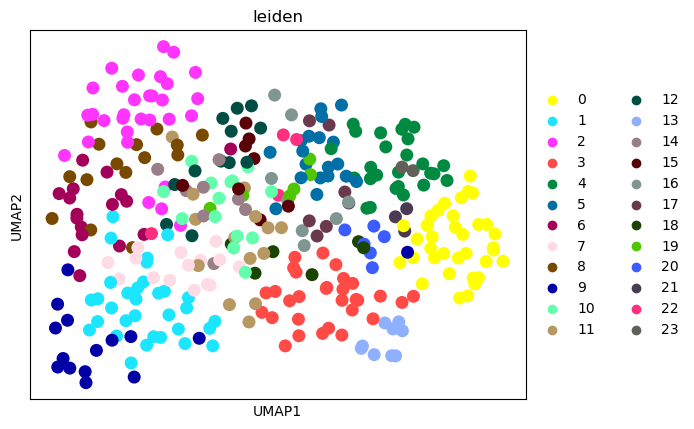

In [57]:
sc.pl.umap(gene_adata_hvg,color='leiden')

In [81]:
# The function is modified from https://github.com/bowang-lab/scGPT
import collections
def get_metagenes(gdata):
    metagenes = collections.defaultdict(list)
    for x, y in zip(gdata.obs["leiden"], gdata.var.index):
        metagenes[x].append(y)
    return metagenes

metagenes = get_metagenes(gene_adata_hvg)

# Obtain the set of gene programs from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes

In [82]:
mgs
#gene_adata_hvg.obs["leiden"]
#gene_adata_hvg.var.index

{'12': ['A1CF',
  'ABCA5',
  'ACAD9',
  'ADCY3',
  'AMH',
  'ARHGAP27',
  'ARHGAP8',
  'ARSA',
  'ATG16L2',
  'B4GALT2',
  'BCDIN3D',
  'BRCA2'],
 '20': ['A2ML1', 'AASS', 'ALG3', 'ANKRD2', 'BLVRB', 'C2orf73'],
 '5': ['AAAS',
  'ABCC2',
  'ABCG5',
  'ABITRAM',
  'ADAM19',
  'AGTRAP',
  'AK8',
  'AKT2',
  'APOBEC3H',
  'ARHGAP29',
  'ARHGEF26',
  'ARHGEF5',
  'ARMC5',
  'ATOH8',
  'BCAT1',
  'BCO1',
  'BEX5',
  'BTBD19',
  'C3orf84'],
 '13': ['AARD',
  'ADGRL3',
  'AFF2',
  'ALDH4A1',
  'ANO4',
  'ARHGAP36',
  'BAMBI',
  'BICRA',
  'C18orf54'],
 '19': ['ABCA13', 'ADGRA2', 'AP5Z1', 'ARHGAP44', 'BACE2', 'C20orf204'],
 '8': ['ABCA9',
  'ABCC3',
  'ADAMTS10',
  'ADGRF5',
  'AGT',
  'AMIGO2',
  'ANAPC4',
  'ANKRD37',
  'ARHGEF1',
  'ARHGEF28',
  'ATP13A1',
  'BAHD1',
  'BCAS4',
  'BRINP2',
  'C11orf80'],
 '2': ['ABCB8',
  'ABCD2',
  'ABHD5',
  'ACAD10',
  'ACADS',
  'ADAMTS15',
  'ADCY9',
  'ADGRL1',
  'AIF1L',
  'AIRE',
  'AKAP1',
  'ALCAM',
  'AMOT',
  'AMZ2',
  'ANKRD45',
  'ARHGEF17',
  '

In [60]:
import pickle
with open ('mgs.pkl','wb') as f:
    pickle.dump(mgs,f)

In [61]:
len(mgs)

21

In [62]:
# The function is modified from https://github.com/bowang-lab/scGPT

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
def score_metagenes(adata, metagenes):
    for p, genes in tqdm(metagenes.items()):
        try:
            sc.tl.score_genes(adata, score_name=str(p) + "_SCORE", gene_list=genes)
            scores = np.array(adata.obs[str(p) + "_SCORE"].tolist()).reshape(-1, 1)
            scaler = MinMaxScaler()
            scores = scaler.fit_transform(scores)
            scores = list(scores.reshape(1, -1))[0]
            adata.obs[str(p) + "_SCORE"] = scores
        except Exception as e:
            adata.obs[str(p) + "_SCORE"] = 0.0

In [67]:
#adata = sc.read_h5ad('./data/zheng_downsampled_cd8t_b_mono.h5ad')

#sc.pp.normalize_total(adata)
#sc.pp.log1p(adata)

score_metagenes(adata,mgs)

  0%|          | 0/21 [00:00<?, ?it/s]

       'ATG16L2', 'B4GALT2', 'BCDIN3D', 'BRCA2'],
      dtype='object')
       'APOBEC3H', 'ARHGAP29', 'ARHGEF26', 'ARHGEF5', 'ARMC5', 'ATOH8',
       'BCAT1', 'BCO1', 'BEX5', 'BTBD19', 'C3orf84'],
      dtype='object')
       'BICRA', 'C18orf54'],
      dtype='object')
       'ANKRD37', 'ARHGEF1', 'ARHGEF28', 'ATP13A1', 'BAHD1', 'BCAS4', 'BRINP2',
       'C11orf80'],
      dtype='object')
       'ADGRL1', 'AIF1L', 'AIRE', 'AKAP1', 'ALCAM', 'AMOT', 'AMZ2', 'ANKRD45',
       'ARHGEF17', 'ARHGEF19', 'ARL4D', 'ARMCX4', 'AS3MT', 'ATP2B2', 'ATP8B4',
       'ATXN7L3', 'B4GALT5', 'BAIAP2L1', 'BCL2L11', 'BCL6', 'BICDL2', 'BRD3OS',
       'BRD8', 'C11orf87'],
      dtype='object')
       'AGPAT4', 'AKAP10', 'AKAP14', 'ALKBH3', 'ALX3', 'ANKRD6', 'ANO1',
       'ANXA11', 'ANXA13', 'ANXA4', 'APOBEC2', 'ARFGAP3', 'ARID5B', 'ASF1A',
       'ASNSD1', 'ATG12', 'ATG4D', 'BCAR1', 'BEGAIN', 'BET1', 'BMP6', 'BPNT1',
       'C15orf40', 'C17orf58', 'C19orf81', 'C19orf85', 'C2orf68', 'C4orf3'],
      dtype='

100%|██████████| 21/21 [00:00<00:00, 268.62it/s]


In [68]:
adata

AnnData object with n_obs × n_vars = 516 × 16711
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'percent.mt', 'sizeFactors', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.5', 'seurat_clusters', 'CellType', 'CellType_manual', '12_SCORE', '20_SCORE', '5_SCORE', '13_SCORE', '19_SCORE', '8_SCORE', '2_SCORE', '0_SCORE', '1_SCORE', '4_SCORE', '3_SCORE', '9_SCORE', '18_SCORE', '11_SCORE', '17_SCORE', '6_SCORE', '7_SCORE', '16_SCORE', '14_SCORE', '15_SCORE', '10_SCORE'
    var: 'features', 'old_names'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances'

In [71]:
genescoreadata
scorelist

['12_SCORE',
 '20_SCORE',
 '5_SCORE',
 '13_SCORE',
 '19_SCORE',
 '8_SCORE',
 '2_SCORE',
 '0_SCORE',
 '1_SCORE',
 '4_SCORE',
 '3_SCORE',
 '9_SCORE',
 '18_SCORE',
 '11_SCORE',
 '17_SCORE',
 '6_SCORE',
 '7_SCORE',
 '16_SCORE',
 '14_SCORE',
 '15_SCORE',
 '10_SCORE']

In [72]:
scorelist = [x for x in adata.obs.columns if x.__contains__('SCORE')]
genescoreadata = sc.AnnData(adata.obs[scorelist])
genescoreadata.obs = adata.obs.iloc[:,:3].copy()
sc.tl.rank_genes_groups(adata,groupby='CellType')

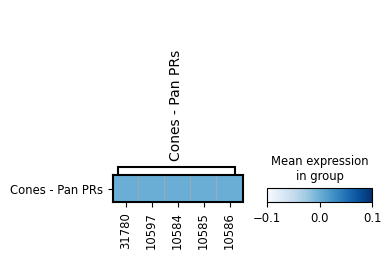

In [75]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, standard_scale='var', cmap='Blues',save='celltype_module')

In [83]:
genesub =list(genesub)
print(genesub)

['A1CF', 'ABCA5', 'ACAD9', 'ADCY3', 'AMH', 'ARHGAP27', 'ARHGAP8', 'ARSA', 'ATG16L2', 'B4GALT2', 'BCDIN3D', 'BRCA2']


In [ ]:
# df1 = gene_adata_hvg.to_df
# print(df1)
df2 = pd.DataFrame(gene_adata_hvg.X,index=gene_adata_hvg.obs_names,columns=gene_adata_hvg.var_names)
#print(df2)
df2_t = df2.transpose()
genesub = mgs['12']
genesub =list(genesub)
clust12df = df2_t.loc[genesub]

<bound method AnnData.to_df of AnnData object with n_obs × n_vars = 343 × 3125
    obs: 'leiden'
    uns: 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'>
         A1CF     A2ML1      AAAS      AARD      AASS    ABCA13     ABCA5  \
1   -0.029065 -0.005372 -0.114743 -0.112098 -0.169690 -0.084562 -0.346212   
2   -0.092340  0.004172 -0.100836 -0.128004 -0.117614 -0.043266 -0.249092   
4   -0.077428 -0.003263 -0.105324 -0.128132 -0.132012 -0.064145 -0.305729   
5   -0.100685  0.000377 -0.083629 -0.096238 -0.146213 -0.038254 -0.323039   
6   -0.079831  0.011001 -0.090202 -0.162864 -0.121616 -0.120161 -0.200099   
..        ...       ...       ...       ...       ...       ...       ...   
509 -0.113288 -0.004302 -0.083514 -0.185191 -0.242597 -0.069888 -0.429932   
510 -0.095878  0.014114 -0.084381 -0.168374 -0.019550 -0.080027 -0.317537   
511 -0.100276  0.015107 -0.084346 -0.148606 -0.159394 -0.107632 -0.367042   
512 -0.108053  0.

In [86]:
clust12df

,1,2,4,5,6,10,12,13,15,17,...,501,502,503,507,508,509,510,511,512,514
A1CF,-0.029065,-0.092340,-0.077428,-0.100685,-0.079831,-0.103836,-0.097853,-0.101262,-0.133450,-0.069199,...,-0.102030,-0.092274,-0.119037,-0.087972,-0.039798,-0.113288,-0.095878,-0.100276,-0.108053,-0.099909
ABCA5,-0.346212,-0.249092,-0.305729,-0.323039,-0.200099,-0.359173,-0.357415,-0.378974,-0.368221,-0.269713,...,-0.376359,-0.311317,-0.433377,-0.393358,-0.235845,-0.429932,-0.317537,-0.367042,-0.310519,-0.364620
ACAD9,-0.081819,-0.042977,-0.067011,-0.035952,-0.026111,-0.022897,-0.026598,0.017152,0.065669,-0.021078,...,-0.021283,-0.028738,-0.031028,-0.032708,-0.053053,-0.028110,-0.022582,-0.032530,-0.049679,-0.021429
ADCY3,-0.084793,-0.056202,-0.061494,-0.052884,-0.047344,-0.049889,-0.049325,-0.050284,-0.064342,-0.045773,...,-0.052581,-0.056300,-0.076259,-0.054718,-0.047859,-0.083233,-0.066334,-0.085645,-0.082937,-0.071963
AMH,-0.147768,-0.066295,-0.098685,-0.060693,-0.069395,-0.094269,-0.117098,-0.127178,-0.223044,-0.093698,...,-0.112855,-0.100404,-0.062909,-0.095736,-0.076377,-0.102700,0.223724,-0.075988,-0.055975,-0.099199
ARHGAP27,-0.047974,-0.052980,-0.043622,-0.040638,-0.044847,-0.051240,-0.042002,-0.051900,-0.071494,-0.049366,...,-0.044508,-0.048492,-0.077834,-0.044893,-0.037284,-0.052369,-0.069908,-0.060851,-0.056554,-0.063354
ARHGAP8,-0.027761,-0.033363,-0.027233,-0.022628,-0.029989,-0.020563,-0.026495,-0.017941,-0.002452,-0.034818,...,-0.013853,-0.029847,-0.034918,-0.014679,-0.023879,-0.039117,-0.037459,-0.015488,-0.036539,-0.030431
ARSA,0.000863,-0.016973,-0.015346,-0.017348,-0.019830,0.010491,0.013212,0.015461,0.052328,0.019680,...,-0.014297,-0.002709,-0.004956,0.006423,-0.009919,-0.001964,-0.001684,0.068939,-0.019834,0.005282
ATG16L2,-0.112333,-0.083244,-0.082978,-0.089295,-0.078017,-0.089179,-0.079672,-0.101432,-0.098624,-0.071435,...,-0.087458,-0.083012,-0.101130,-0.092938,-0.061697,-0.085490,-0.078935,-0.083216,-0.094878,-0.087018
B4GALT2,-0.083692,0.083067,-0.101870,-0.095201,-0.094905,-0.108304,-0.087858,-0.095983,-0.070243,-0.080293,...,-0.093941,-0.091796,-0.077391,-0.085747,-0.108411,-0.091114,-0.079068,-0.079908,-0.083839,-0.086045


In [36]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

In [87]:
# The function is modified from https://github.com/bowang-lab/scGPT
G = nx.Graph()
similarities = cosine_similarity(clust12df)
genes = list(clust12df.index.values)
similarities[similarities>0.9999]=0
edges = []
nz = list(zip(*similarities.nonzero()))
for n in tqdm(nz):
    edges.append((genes[n[0]], genes[n[1]],{'weight':similarities[n[0],n[1]]}))
G.add_nodes_from(genes)
G.add_edges_from(edges)

100%|██████████| 132/132 [00:00<00:00, 506076.90it/s]


In [88]:
widths = nx.get_edge_attributes(G, 'weight')
weightvalue = np.array(list(widths.values()))
scaled_weightvalue = (weightvalue-weightvalue.min())/(weightvalue.max()-weightvalue.min())*3

In [89]:
widsorted = sorted(widths.items(), key=lambda x: x[1], reverse=True)

In [90]:
toppair = np.array(list(widths))[weightvalue.argsort()<3]

In [91]:
G

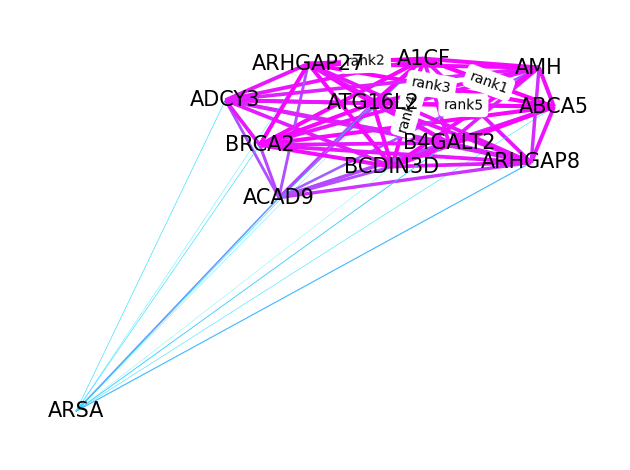

In [92]:
import matplotlib as mpl
import matplotlib.pyplot as plt
pos = nx.spring_layout(G, k=0.4, iterations=15, seed=42)

nx.draw_networkx_edges(G, pos,
                       edgelist = widths.keys(),
                       edge_color=list(widths.values()),
                       width=scaled_weightvalue,
                       edge_cmap=mpl.colormaps['cool'],
                       alpha=1)

nx.draw_networkx_labels(G, pos, font_size=15, font_family="sans-serif")

# edge weight labels
edge_labels = {widsorted[i][0]: f'rank{i+1}' for i in range(5)}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.savefig('figures/T_genemodule.pdf',bbox_inches='tight')

## Use emb for pySCENIC

In [ ]:
cell_geneemb = np.load('./data/cd8t_b_mono_geneemb_01B-resolution_singlecell_gene_embedding_f1_resolution.npy')

In [ ]:
selected_gene = adata.X.sum(0)>0
geneemb_merge = cell_geneemb[:,selected_gene,:].mean(0)
geneemb_merge.shape

In [ ]:
TF = pd.read_csv('./data/allTFs_hg38.txt',header=None).values.T[0]
sgene = np.array(gene_list)[selected_gene]
fltTF = [x for x in TF if x in sgene]
len(fltTF)

In [ ]:
fltgeneembdf = pd.DataFrame(geneemb_merge,index=sgene)

In [ ]:
coexplist=[]
for tf in tqdm(fltTF):
    tmpsim = cosine_similarity(fltgeneembdf.loc[fltTF[0],:].values.reshape(1,-1),fltgeneembdf)
    tmpsim[tmpsim>0.9999]=0
    tmpsimdf = pd.DataFrame(tmpsim,columns=sgene,index=['simi']).T
    tmpsimdf = tmpsimdf.sort_values('simi',ascending=False)
    for idx in range(1000):
        coexplist.append([tf,tmpsimdf.index[idx],tmpsimdf.iloc[idx,0]*100])

In [ ]:
grndf = pd.DataFrame(coexplist,columns=['TF','target','importance'])

In [ ]:
grndf.to_csv('scf_grn_1000.tsv',index=False,sep='\t')

In [ ]:
grndf.head()

feed into pyscenic

#bin/bash

docker run -it --rm \
    -v /nfs_beijing/:/nfs_beijing/ \
    aertslab/pyscenic:0.12.1 pyscenic ctx \
        ./geneemb/scf_grn_1000.tsv \
        ./geneemb/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
        --annotations_fname ./geneemb/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \
        --expression_mtx_fname ./geneemb/data/zheng_subset_cd8t_b_mono.tsv \
        --mode "custom_multiprocessing" \
        --output ./geneemb/regulons_1000.csv \
        --num_workers 40
        
docker run -it --rm \
    -v /nfs_beijing/:/nfs_beijing/ \
    aertslab/pyscenic:0.12.1 pyscenic aucell \
        ./geneemb/data/zheng_subset_cd8t_b_mono.tsv \
        ./geneemb/regulons_1000.csv \
        -o ./geneemb/auc_mtx_1000.csv \
        --num_workers 6

In [ ]:
# from another notebook for post-analysis
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
from pyscenic.binarization import binarize

In [ ]:
auc_mtx = pd.read_csv('./auc_mtx_1000.csv',index_col=0)

In [ ]:
cellanno = pd.DataFrame(['CD8+ Cytotoxic T']*100+['CD19+ B']*100+['CD14+ Monocyte']*100,columns=['anno'])

In [ ]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellanno['anno'] )
rss_cellType.to_csv('RSS.csv')
rss_cellType

In [ ]:
from adjustText import adjust_text
cats = sorted(list(set(cellanno['anno'])))

fig = plt.figure(figsize=(15, 5))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(1,3,num)
    plot_rss(rss_cellType, c, top_n=3, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig('RSS.pdf',bbox_inches='tight')